# modules imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time as time
import tqdm 
import os
from scipy.stats import chisquare

In [1]:
import os
import datetime
Enrich_Path =r"C:\Users\Persona.ly_DS1\Desktop\Technion\Data Processing\1. Data Reading and Enrichments"
os.chdir(Enrich_Path)
from sklearn.cluster import KMeans

In [204]:
def isin6(x):
    if type(x) == float:
        return np.nan
    elif (set(x.split()) & set(top7)) == set():
        return 0
    return 1

In [2]:
%run Reading&Enrichments.ipynb

Reading&Enrichments.ipynb:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  "# Reading the data and adding Enrichments"


In [3]:
Col_Filter = [
                    'crid','uadeviceram','ppi','time','height','bidtime'#,'install'
                    'Impression_Price','bid','impr','installprice','bidtime','Impression_Price',
                    'month','apps','ssps','bundleAvgUserRating','uareleaseyear','device_age'
            ]
corr = df[[x for x in df.columns if x not in Col_Filter]].corr()
corr.style.background_gradient(cmap='coolwarm')

,install,uabatterycapacity,bundletotalfc,Local_day_of_week,normal_apps,normal_ssps,normal_rate,isLandscape,log2ofstorage
install,1,-0.00209074,-0.0408842,0.00277454,-0.00265972,-0.0195333,0.0021574,0.00870566,-0.000796633
uabatterycapacity,-0.00209074,1,0.047096,0.00446871,-0.0386626,-0.110214,-0.0484206,0.0150964,0.0226191
bundletotalfc,-0.0408842,0.047096,1,-0.000590892,-0.0147834,0.100103,-0.0385275,0.0133794,0.00846021
Local_day_of_week,0.00277454,0.00446871,-0.000590892,1,0.00079213,0.000634269,-0.000292646,0.0177078,0.00938282
normal_apps,-0.00265972,-0.0386626,-0.0147834,0.00079213,1,0.514269,-0.0232559,-0.00121992,0.0284524
normal_ssps,-0.0195333,-0.110214,0.100103,0.000634269,0.514269,1,0.0291881,-0.0174431,0.0760816
normal_rate,0.0021574,-0.0484206,-0.0385275,-0.000292646,-0.0232559,0.0291881,1,0.115732,-0.055177
isLandscape,0.00870566,0.0150964,0.0133794,0.0177078,-0.00121992,-0.0174431,0.115732,1,-0.023711
log2ofstorage,-0.000796633,0.0226191,0.00846021,0.00938282,0.0284524,0.0760816,-0.055177,-0.023711,1


# Data Exploration

### Checking IInstall Rate per feature

### Device age in years

In [4]:
df['device_age'] = datetime.datetime.now().year - df.uareleaseyear

In [5]:
d_age_min = df.device_age.min()
d_age_max = df.device_age.max()
df['d_age_normalized'] = df.device_age.apply(lambda x: (x-d_age_min)/(d_age_max-d_age_min))

In [6]:
prior_inst_rate = sum(df.install)/ len(df.install)
prior_inst_rate

0.005313822369134262

## install rate per normalized device age in years  with prior install rate threshold

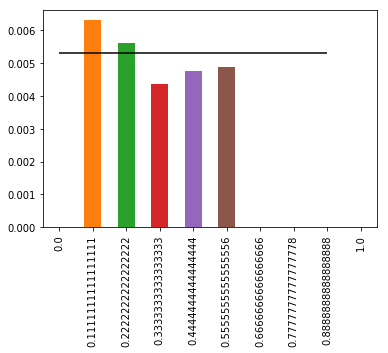

In [7]:
(df[df.install == 1].d_age_normalized.value_counts()/df.d_age_normalized.value_counts()).plot.bar()
plt.hlines(prior_inst_rate,xmin = 0,xmax = 8)

## install rate per bundletotalfc feature with prior install rate threshold

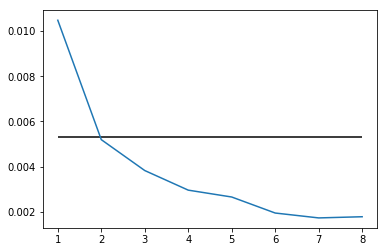

In [8]:
(df[df.install == 1].bundletotalfc.value_counts()/df.bundletotalfc.value_counts()).plot()
plt.hlines(prior_inst_rate,xmin = 1,xmax = 8)

### Oreintation Exploration 

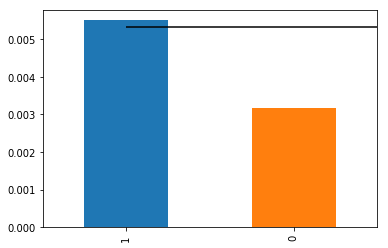

In [9]:
(df[df.install == 1].isLandscape.value_counts()/df.isLandscape.value_counts()).plot.bar()
plt.hlines(prior_inst_rate,xmin = 0,xmax = 8)

In [14]:
df.isLandscape.value_counts()

1    500681
0     43560
Name: isLandscape, dtype: int64

## Same Main Category. in this case  - Casino

In [11]:
df['cat_is_casino'] = 1*df.bundleCategory.str.contains('casino',na=False)

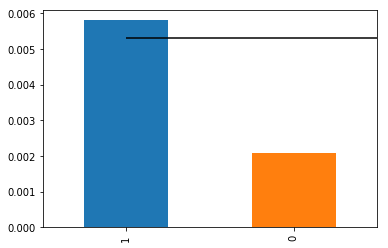

In [12]:
(df[df.install == 1].cat_is_casino.value_counts()/df.cat_is_casino.value_counts()).plot.bar()
plt.hlines(prior_inst_rate,xmin = 0,xmax = 8)

## Taking Care of normalized_apps - normalized_ssps high correlation with clustring into 4 groups using k means


In [15]:
df.normal_apps = df.normal_apps.fillna('-1')
df.normal_ssps = df.normal_ssps.fillna('-1')

len(df[df.normal_apps == '-1'])
# 2 records of na , discarded

df = df[df.normal_apps != '-1']

In [16]:
kmeans = KMeans(n_clusters=4).fit(df[['normal_ssps','normal_apps']])
centroids = kmeans.cluster_centers_
print(centroids)

[[0.4711653  0.0266905 ]
 [0.10599936 0.00324576]
 [0.30172886 0.01196837]
 [0.64752908 0.05186368]]


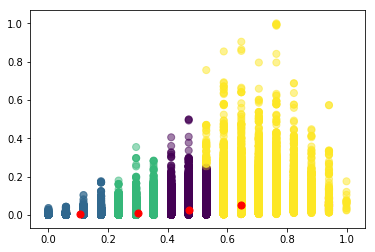

In [24]:
plt.scatter(df['normal_ssps'], df['normal_apps'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)


In [25]:
#adding back the feature to the table.

apps_ssps = pd.DataFrame(kmeans.labels_,columns = ['Clustered_Apps_Ssps'])
df = df.reset_index()
df = df.join(apps_ssps)

In [26]:
prior_ROAS = 100*df.installprice.sum()/ df.Impression_Price.sum()

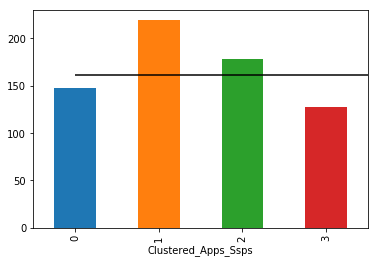

In [27]:
Eval_matrix = df[[
                    'Clustered_Apps_Ssps','Impression_Price','installprice'
                ]].groupby(by='Clustered_Apps_Ssps').sum()

Eval_matrix['ROAS'] = 100*Eval_matrix.installprice / Eval_matrix.Impression_Price

Eval_matrix.ROAS.plot.bar()
plt.hlines(prior_ROAS,xmin = 0, xmax = 4)

## Exploration of crids 

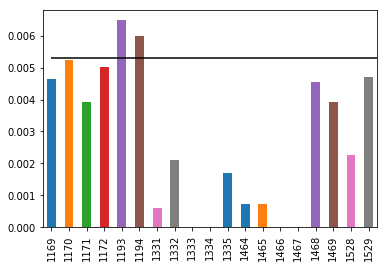

In [51]:
(df[df.install ==1].crid.value_counts()/df.crid.value_counts()).plot.bar()
plt.hlines(prior_inst_rate,xmin = 0,xmax = 20)

In [49]:
crids = df[['crid','Impression_Price','installprice']].groupby('crid').sum()
crids['ROAS'] = 100*crids.installprice/crids.Impression_Price

In [58]:
#Creating a threshold of aggregated amount of spend of 180$
crids= crids[crids.Impression_Price > 180]
crids

,Impression_Price,installprice,ROAS
crid,,,
1169,2067.436909,3000.0,145.107209
1170,1242.925590,1990.0,160.106125
1171,499.429231,620.0,124.141712
1193,2241.071788,4295.0,191.649372
1194,2123.986538,3600.0,169.492600
1468,209.284184,300.0,143.345758
1469,215.169498,270.0,125.482470


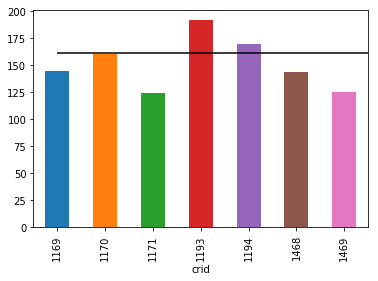

In [59]:
crids.ROAS.plot.bar()
plt.hlines(prior_ROAS,xmin = 0, xmax = 20)

### SiteName Engineering of words

In [132]:
df.sitename.head(10)

0                       Zombie Ghosts Coin Party Dozer
1    Slots! CashHit Slot Machines & Casino Games Party
2    Cashmania Slots 2019: Free Vegas Casino Slot G...
3                   GSN Casino - Mediation (no blocks)
4           Lucky CASH Slots - Win Real Money & Prizes
5                                           Free Slots
6              Cleopatra Slots Fortunes of Luxor Egypt
7           Lucky CASH Slots - Win Real Money & Prizes
8     Viva Slots Vegas™ Free Slot Jackpot Casino Games
9        Royal Slots Free Slot Machines & Casino Games
Name: sitename, dtype: object

In [133]:
set_aside = set(df.sitename)
set_aside = list(set_aside)
set_aside2= []
for i in set_aside:
    if type(i) == str:
        set_aside2 = set_aside2 + i.split()

In [134]:
set_aside = pd.DataFrame(set_aside2)[0].value_counts().reset_index().rename(columns = {"index":'word',0:'Count'})
set_aside = set_aside[set_aside.word.astype(str).str.contains('[A-Za-z]')]

### get 7 top words in description

In [203]:
global top7
top7 = set_aside.word.head(7).tolist()

In [205]:
df['isintop6words'] = df.sitename.apply(isin6)

In [209]:
df.head()

,index,time,bidtime,bidid,type,crid,deviceid,devlang,sspid,bundle,siteid,sitename,bid,impr,install,installprice,make,model,osv,isp,state,useroffset,height,uadevicetype,uabatterycapacity,uadeviceram,uareleaseyear,ppi,displaymanagerver,ssps,apps,bundletotalfc,month,Impression_Price,bundleCategory,bundleAvgUserRating,date,time_diff,local time,Local_day_of_week,normal_apps,normal_ssps,normal_rate,isLandscape,log2ofstorage,device_age,d_age_normalized,cat_is_casino,Clustered_Apps_Ssps,isintop6words
0,4,1.548845e+09,1548845084493,674a6c69-532e-45ac-8f07-81d60a9a06eb,impression,1468,df23d29a-3750-4789-8b2c-4cca6a36772e,en,chartboost,com.mindstormstudios.coinparty.google,561cb22af6cd4540a550863b,Zombie Ghosts Coin Party Dozer,NaN,1.0,0.0,0.0,LG,LM-V405,8.1,AT&T U-verse,IL,-06:00,480.0,SmartPhone,3300.0,6144.0,2018.0,536.92,6.6.1,4.0,5.0,2.0,1,0.023375,"games,games/casino",4.4,2019-01-30 10:45:28.733999968,06:00:00,2019-01-30 04:45:28.733999968,2.0,0.00564175,0.176471,0.850,0,6.0,1.0,0.111111,1,1,0.0
1,6,1.548845e+09,1548844905459,232a81e4-60cb-4e9b-a862-afa2a4a797a3,impression,1169,0bd1dc48-3b67-43c5-bc1f-106172d74790,en,unity_us,com.vegasslotspocket.heartofdiamond,df5e19e291e3e1b140cb9b70dcbd9ebc,Slots! CashHit Slot Machines & Casino Games Party,NaN,1.0,0.0,0.0,Samsung,SM-S327VL,6,West Central Telephone Assn,MN,-06:00,720.0,SmartPhone,2600.0,1536.0,2017.0,293.72,NaN,6.0,8.0,3.0,1,0.020130,"games,games/board,games/casino",4.7,2019-01-30 10:45:35.161000013,06:00:00,2019-01-30 04:45:35.161000013,2.0,0.00987306,0.294118,0.925,1,4.0,2.0,0.222222,1,2,1.0
2,11,1.548845e+09,1548845209785,6d9feae9-1d70-4429-97ec-f6ae6aad14a1,impression,1194,959e3d81-edde-4b01-a168-1b7a6f336eed,en,chartboost,com.zealgames.cashmania,5b39e39c6a0af32a0caed759,Cashmania Slots 2019: Free Vegas Casino Slot G...,NaN,1.0,0.0,0.0,Samsung,SM-J737P,8,Spectrum,WI,-06:00,320.0,SmartPhone,3300.0,2048.0,2018.0,267.02,7.3.1,10.0,12.0,3.0,1,0.020700,"games,games/casino",4.7,2019-01-30 10:46:53.872999907,06:00:00,2019-01-30 04:46:53.872999907,2.0,0.0155148,0.529412,0.925,1,5.0,1.0,0.111111,1,0,1.0
3,13,1.548845e+09,1548845211500,8f893eea-c785-48ef-98cb-67adf6c7395f,impression,1193,9852f122-18cb-4f26-b445-fbdf961eeff2,en,adcolony,com.gsn.android.casino,0343291e164bbc22dc7139eb918db7a9,GSN Casino - Mediation (no blocks),NaN,1.0,0.0,0.0,NaN,NaN,8.1,Spectrum,WI,-06:00,320.0,NaN,NaN,NaN,NaN,NaN,3.3.5,11.0,25.0,1.0,1,0.008312,"games,games/casino",4.3,2019-01-30 10:47:27.193000078,06:00:00,2019-01-30 04:47:27.193000078,2.0,0.0338505,0.588235,0.825,1,NaN,NaN,NaN,1,3,1.0
4,21,1.548845e+09,1548845308448,b5f53834-9373-4a15-9cbd-893522584329,impression,1469,e84ab04d-179c-4c5c-853a-b41a1d9f2dab,en,adcolony,com.fortmasongames.confetti,14a247c9b52706c521f7d51578244e4b,Lucky CASH Slots - Win Real Money & Prizes,NaN,1.0,0.0,0.0,Samsung,SM-G930A,8,Suddenlink Communications,AR,-06:00,480.0,SmartPhone,3000.0,4096.0,2016.0,575.92,3.2.0,11.0,53.0,2.0,1,0.041311,"games,games/casino",4.6,2019-01-30 10:48:52.743000031,06:00:00,2019-01-30 04:48:52.743000031,2.0,0.0733427,0.588235,0.900,0,5.0,3.0,0.333333,1,3,1.0
5,24,1.548845e+09,1548845126356,a11f6edd-c023-4e65-bf3c-d874459cbbae,impression,1169,7d7e866a-2deb-4402-9e79-6a734641a02b,en,unity_us,com.huuuge.bestslots,89a4336fd3f43bce061240b9aa133b84,Free Slots,NaN,1.0,0.0,0.0,NaN,QS5509A,8.1,Comcast Cable,NM,-07:00,480.0,SmartPhone,3000.0,1024.0,2018.0,178.12,NaN,9.0,19.0,8.0,1,0.015110,"games,games/casino",4.6,2019-01-30 10:49:21.927999973,07:00:00,2019-01-30 03:49:21.927999973,2.0,0.0253879,0.470588,0.900,1,4.0,1.0,0.111111,1,0,1.0
6,32,1.548843e+09,1548843261935,30b2f90e-34b7-40bc-8e70-384b56ad3125,impression,1170,a61a24d8-8fbf-4805-8798-a838028c012c,en,chartboost,com.bluewater.g.luxor,5b15940f88ad040b710baf11,Cleopatra Slots Fortunes of Luxor Egypt,NaN,1.0,0.0,0.0,Samsung,SM-S327VL,6.0.1,Verizon Wireless,NaN,NaN,320.0,SmartPhone,2600.0,1536.0,2017.0,293.72,6.6.3,6.0,5.0,1.0,1,0.012602,"games,games/casino",2.7,2019-01-30 10:15:20.378999949,NaT,NaT,NaN,0.

In [210]:
Col_Filter = [
                    'crid','uadeviceram','ppi','time','height','bidtime'#,'install'
                    'Impression_Price','bid','impr','installprice','bidtime','Impression_Price',
                    'month','apps','ssps','bundleAvgUserRating','uareleaseyear','device_age'
            ]
corr = df[[x for x in df.columns if x not in Col_Filter]].corr()
corr.style.background_gradient(cmap='coolwarm')

,index,install,uabatterycapacity,bundletotalfc,Local_day_of_week,normal_rate,isLandscape,log2ofstorage,d_age_normalized,cat_is_casino,Clustered_Apps_Ssps,isintop6words
index,1,-0.000419155,0.00107977,0.00613681,0.00320295,-0.00568794,0.00442531,-0.00336185,-0.000931083,0.0106396,0.000793267,0.00664871
install,-0.000419155,1,-0.00209074,-0.0408842,0.00277454,0.0021574,0.00887936,-0.000796633,-0.00808158,0.0173611,-0.00367825,0.0123708
uabatterycapacity,0.00107977,-0.00209074,1,0.047096,0.00446871,-0.0484206,0.0150964,0.0226191,0.295346,0.00886226,-0.050946,0.00456376
bundletotalfc,0.00613681,-0.0408842,0.047096,1,-0.000590892,-0.0385275,0.0133794,0.00846021,0.0703572,0.0831849,0.0123829,0.0590956
Local_day_of_week,0.00320295,0.00277454,0.00446871,-0.000590892,1,-0.000292646,0.0177078,0.00938282,0.00695962,0.00215756,-0.000541266,0.00894628
normal_rate,-0.00568794,0.0021574,-0.0484206,-0.0385275,-0.000292646,1,0.115732,-0.055177,-0.0206902,0.175929,-0.0136043,0.27766
isLandscape,0.00442531,0.00887936,0.0150964,0.0133794,0.0177078,0.115732,1,-0.023711,0.00882442,0.0333433,-0.00695423,0.182252
log2ofstorage,-0.00336185,-0.000796633,0.0226191,0.00846021,0.00938282,-0.055177,-0.023711,1,-0.217455,0.0190179,0.0385587,-0.00984805
d_age_normalized,-0.000931083,-0.00808158,0.295346,0.0703572,0.00695962,-0.0206902,0.00882442,-0.217455,1,-0.00264437,-0.0119795,0.0130313
cat_is_casino,0.0106396,0.0173611,0.00886226,0.0831849,0.00215756,0.175929,0.0333433,0.0190179,-0.00264437,1,-0.0285312,0.396686
